In [3]:
import matplotlib.pyplot as plt

import random
import numpy as np
import scipy.special as SS
import scipy.stats as SSA
from scipy import sparse

import pandas as pd
import copy
import math
import os
import sys
import time

import gzip, tempfile
from pathlib import Path

In [4]:
import numpy as np

def make_reporting_rate(N=3142, T=60, mode="linear", es_idx=0, k=6.0):
    """
    Returns an array of shape (N, T) with reporting rates.
    Bounds increase over time:
        low_t:  0.10 -> 0.15
        high_t: 0.15 -> 0.20

    Modes
    -----
    linear:
        For each location, draw:
          start ~ U[0.10, 0.15]  at t=0
          end   ~ U[0.15, 0.20]  at t=T-1
        Then linearly interpolate between start and end.

    sigmoid:
        Global sigmoid time schedule between the same bounds,
        each location gets a fixed quantile inside [low_t(t), high_t(t)].

    plateau:
        For each location, draw:
          start ~ U[0.10, 0.15]  at t=0
          end   ~ U[0.15, 0.20]  at t=t_plateau (default t_plateau=28)
        Then linearly interpolate from t=0 to t_plateau,
        and keep the rate constant at `end` from t_plateau to T-1.

    sigmoid_local:
        For each location:
          start_i ~ U[0.10, 0.15] at t=0
          end_i   ~ U[0.15, 0.20] at t=T-1
        And an individual sigmoid in time:
          r_i(t) = start_i + (end_i - start_i) * s_i(t)
        where s_i(t) is a monotone sigmoid normalized so that
          s_i(0) = 0, s_i(T-1) = 1, with location-specific steepness.

    Args:
        N: number of locations
        T: number of time steps
        mode: 'linear', 'sigmoid', 'plateau', or 'sigmoid_local'
        es_idx: seed to fully control randomness
        k: steepness of the sigmoid (only used if mode='sigmoid')

    Returns:
        rates: np.ndarray, shape (N, T)
    """
    # Reproducible per-es_idx RNG
    rng = np.random.default_rng(np.random.SeedSequence(es_idx))

    t = np.arange(T)

    if mode == "linear":
        # time fraction in [0,1]
        s = np.linspace(0.0, 1.0, T) if T > 1 else np.array([0.0])

        # per-location start/end
        start = rng.uniform(0.10, 0.15, size=(N, 1))  # T0
        end   = rng.uniform(0.15, 0.20, size=(N, 1))  # T(T-1)

        # constant-speed linear interpolation for all t
        rates = start + (end - start) * s[None, :]

        np.clip(rates, 0.10, 0.20, out=rates)

    elif mode == "sigmoid":
        # Centered sigmoid mapped to [0,1]
        x = (t - (T - 1) / 2) / (T - 1)          # roughly in [-0.5, 0.5]
        z = 1.0 / (1.0 + np.exp(-k * x))         # sigmoid
        s = (z - z.min()) / (z.max() - z.min())  # normalize to [0,1]

        # Time-varying bounds
        low_t   = 0.10 + 0.05 * s      # shape (T,)
        high_t  = 0.15 + 0.05 * s      # shape (T,)
        width_t = high_t - low_t       # here always 0.05, shape (T,)

        # Fixed per-location quantile in [0,1]
        q = rng.uniform(0.0, 1.0, size=(N, 1))  # shape (N,1)

        # Broadcast to (N,T): low_t[None,:] + q * width_t[None,:]
        rates = low_t[None, :] + q * width_t[None, :]

        np.clip(rates, 0.10, 0.20, out=rates)

    elif mode == "plateau":
        # time index where the linear increase ends and plateau starts
        t_plateau = 28
        t_plateau = min(t_plateau, T - 1)  # in case T < 29

        # per-location start/end
        start = rng.uniform(0.10, 0.15, size=(N, 1))  # value at t=0
        end   = rng.uniform(0.15, 0.20, size=(N, 1))  # value at t=t_plateau

        # linear interpolation from t=0 to t_plateau
        if t_plateau > 0:
            s = np.linspace(0.0, 1.0, t_plateau + 1)  # length = t_plateau+1 (0..t_plateau)
        else:
            s = np.array([0.0])

        rates = np.empty((N, T), dtype=float)

        # 0..t_plateau: linear increase
        rates[:, :t_plateau + 1] = start + (end - start) * s[None, :]

        # t_plateau+1..T-1: plateau at 'end'
        if t_plateau + 1 < T:
            rates[:, t_plateau + 1:] = end  # broadcast final column

        np.clip(rates, 0.10, 0.20, out=rates)

    elif mode == "sigmoid_local":
        # Per-location start/end values
        start = rng.uniform(0.10, 0.15, size=(N, 1))  # value at t=0
        end   = rng.uniform(0.15, 0.20, size=(N, 1))  # value at t=T-1

        # Time axis
        x = (t - (T - 1) / 2) / (T - 1)  # roughly in [-0.5, 0.5], shared across locations

        # Draw location-specific steepness (you can tune these bounds)
        k_loc = rng.uniform(.1, 10.0, size=(N, 1))  # shape (N,1)

        # Compute location-specific sigmoids z_i(t)
        z = 1.0 / (1.0 + np.exp(-k_loc * x[None, :]))  # shape (N,T)

        # Normalize each location's sigmoid to [0,1] over [0, T-1]
        z0 = z[:, [0]]      # shape (N,1)
        zT = z[:, [-1]]     # shape (N,1)
        s = (z - z0) / (zT - z0)  # shape (N,T), s_i(0)=0, s_i(T-1)=1

        # Map to [start_i, end_i]
        rates = start + (end - start) * s

        np.clip(rates, 0.10, 0.20, out=rates)

    else:
        raise ValueError("mode must be 'linear', 'sigmoid', 'plateau', or 'sigmoid_local'")

    return rates


In [5]:
# Linear increase
rates_linear = make_reporting_rate(mode="linear", es_idx=0)
# Sigmoid increase (steeper middle if k larger)
rates_sigmoid = make_reporting_rate(mode="sigmoid", es_idx=123, k=6.0)
# Plateau increase
rates_plateau = make_reporting_rate(mode="plateau", es_idx=123)
# Local sigmoids
rates_sigmoid_local = make_reporting_rate(mode="sigmoid_local", es_idx=123)


In [215]:
# np.savetxt('reporting_rates_test.csv',rates_sigmoid)
rates_sigmoid = np.loadtxt('reporting_rates.csv')

Text(0, 0.5, 'reporting rate')

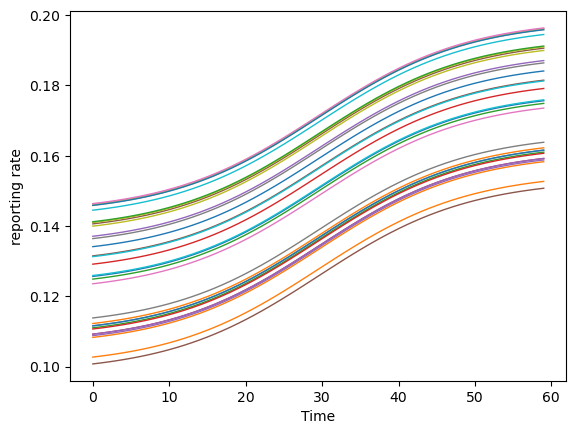

In [172]:
for i in range(31):
    plt.plot(rates_sigmoid[i,:],lw=1)
plt.xlabel('Time')
plt.ylabel('reporting rate')
# plt.axhline(2.2, color='red', linestyle='--', label='R=1')
# plt.axvline(7.0, color='green', linestyle='--', label='R=0')

In [173]:
np.savetxt('reporting_rates_linear.csv',rates_linear)
# rates_linear0 = np.loadtxt('reporting_rates_linear.csv')

In [174]:
# np.sum(rates_linear == rates_linear0) == rates_linear.shape[0] * rates_linear.shape[1]  # should be True

Text(0, 0.5, 'reporting rate')

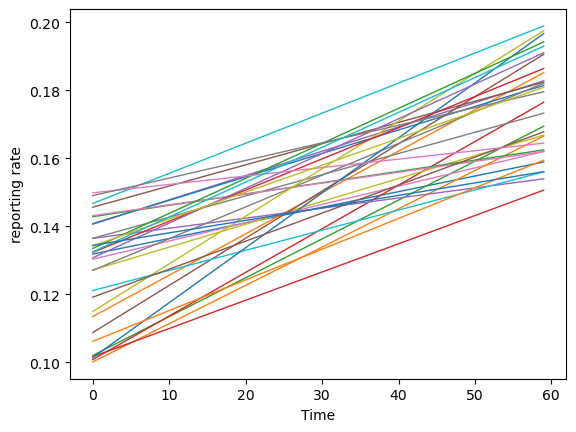

In [175]:
for i in range(31):
    plt.plot(rates_linear[i,:],lw=1)
plt.xlabel('Time')
plt.ylabel('reporting rate')
# plt.axhline(2.2, color='red', linestyle='--', label='R=1')
# plt.axvline(7.0, color='green', linestyle='--', label='R=0')

In [176]:
np.savetxt('reporting_rates_plateau.csv',rates_plateau)
# rates_plateau0 = np.loadtxt('reporting_rates_plateau.csv')

Text(0, 0.5, 'reporting rate')

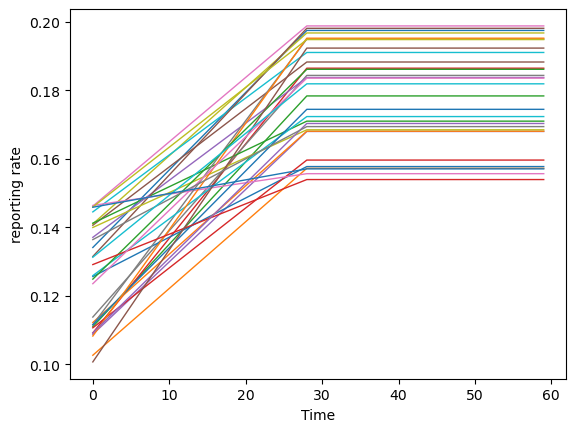

In [177]:
for i in range(31):
    plt.plot(rates_plateau[i,:],lw=1)
plt.xlabel('Time')
plt.ylabel('reporting rate')

In [107]:
np.savetxt('reporting_rates_sigmoid_local.csv',rates_sigmoid_local)
# rates_sigmoid_local = np.loadtxt('reporting_rates_sigmoid_local.csv')        

Text(0, 0.5, 'reporting rate')

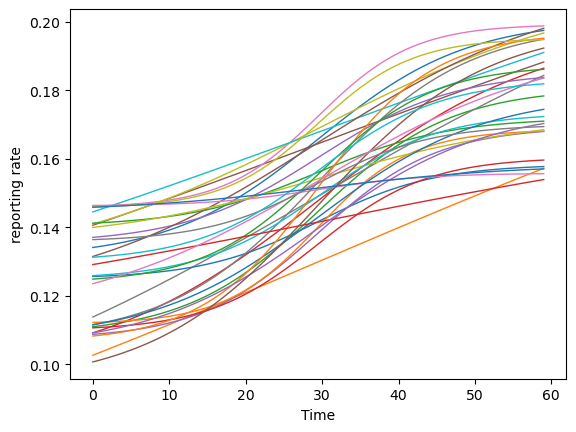

In [108]:
for i in range(31):
    plt.plot(rates_sigmoid_local[i,:],lw=1)
plt.xlabel('Time')
plt.ylabel('reporting rate')

In [109]:
Rtx = np.loadtxt('Rtx_p_synthetic.csv')
# Rtx = np.loadtxt('Rtx_d_synthetic.csv')

In [110]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [111]:
# r_dispersion_ls = [0.06, 0.1, 0.3, 0.6, 1.0, 2.0]
# es_idx_ls = [999, 888, 88, 999, 999, 999]
############################################
# r_dispersion_ls = [0.06, 0.025, 0.1, 0.286, 0.6, 1.0, 2.0, 0.3]
# es_idx_ls = [999, 1, 1, 999, 11, 11, 11, 111]
############################################
# r_dispersion_ls = [0.6, 0.6, 0.6, 1.0, 1.0, 1.0]
# es_idx_ls = [11, 111, 7, 11, 111, 7]
############################################
r_esidx_ls = [(2.0,11), (0.1,1), (0.3,111), (0.06,999), (0.025,1), (0.286,999), (1.0,7), (0.6,11)]
############################################


In [319]:
################################################################
### save the new obervation infections with reporting rates ####
################################################################
r_test_idx = 4
# r_dispersion = r_dispersion_ls[r_test_idx] #0.1 0.025 20.0
# g_idx = es_idx_ls[r_test_idx] #1 999 0
r_dispersion, g_idx = r_esidx_ls[r_test_idx]
print("r_dispersion:",r_dispersion)
print("g_idx:",g_idx)

save_path = '../test_rr_output_pop_sigmoid/'

sub_export_dir = '/Users/qing/Library/CloudStorage/OneDrive-ColumbiaUniversityIrvingMedicalCenter/0_branching_model_review/test_nrr_output_pop/tobeinfered/branching_r-{}/'.format(r_dispersion)
export_names = sub_export_dir+'NewInf_r-{}_{}.npy.gz'.format(np.round(r_dispersion,3),(g_idx))
g_i = load_gzipped_numpy(export_names)

# g_cases = g_i*rates_linear
g_cases = g_i*rates_sigmoid
# g_cases = g_i*rates_plateau
# g_cases = g_i*rates_sigmoid_local

save_dir = Path(save_path + "tobeinfered/")         # make it a Path
save_dir.mkdir(parents=True, exist_ok=True)
out = save_dir / "NewInf_r-{}_{}_rr.npy.gz".format(np.round(r_dispersion,3),g_idx)


with tempfile.NamedTemporaryFile(dir=save_dir, delete=False) as tf:
    tmp = Path(tf.name)

try:
    with gzip.open(tmp, "wb") as f:
        np.save(f, g_cases, allow_pickle=False)  # don't pickle unless you need to
    os.replace(tmp, out)  # atomic rename
finally:
    if tmp.exists():
        try: tmp.unlink()
        except Exception:
            pass

r_dispersion: 0.025
g_idx: 1


In [320]:
np.sum(g_cases)

279745.4640164556

In [321]:
num_locations = g_i.shape[0]
num_days = g_i.shape[1]
# 1D array: 60 values linearly spaced from 0.1 to 0.2
one_location_15 = np.linspace(0.15, 0.2, num_days)
one_location_10 = np.linspace(0.10, 0.2, num_days)
# Repeat this row for each of the 3142 locations → shape (3142, 60)
m_alpha_15 = np.tile(one_location_15, (num_locations, 1))
m_alpha_10 = np.tile(one_location_10, (num_locations, 1))

Text(0.5, 0, 'Time')

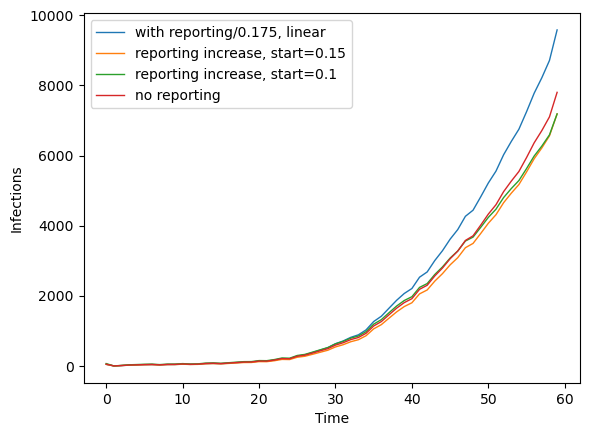

In [322]:
plt.plot(g_cases[1858,:]/0.15,lw=1,label='with reporting/0.175, linear')
plt.plot(g_cases[1858,:]/m_alpha_15[1858,:],lw=1,label='reporting increase, start=0.15')
plt.plot(g_cases[1858,:]/m_alpha_10[1858,:],lw=1,label='reporting increase, start=0.1')
plt.plot(g_i[1858,:],lw=1,label='no reporting')
plt.legend()
plt.ylabel('Infections')
plt.xlabel('Time')
# plt.yscale('log')

In [323]:
assumed_rates = 0.15
infections_reported = np.sum(g_cases,axis=0)
infections_adj = infections_reported/assumed_rates
# infections_adj = infections_reported/m_alpha_10[0,:]
print(infections_reported.shape, infections_adj.shape)

(60,) (60,)


In [324]:
### verify the saved file
save_dir = save_path+'tobeinfered/'
temp = load_gzipped_numpy(save_dir+"NewInf_r-{}_{}_rr.npy.gz" .format(np.round(r_dispersion, 3), g_idx))
np.sum(temp == g_cases) == g_cases.shape[0]*g_cases.shape[1]

True

In [325]:
# Python to R
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter


inc = pd.Series(infections_adj,name="incid")
with localconverter(pandas2ri.converter):
    r_infections = pandas2ri.py2rpy(inc)

# Assign the R object to R's global environment
r.assign("inc", r_infections)
r.assign("r", r_dispersion)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


0.025000


In [326]:
%%R
# This code runs in R
# require(testthat)

# Infer the Rt using EpiEstim in R pacakages if not installed
# install.packages("lubridate")
# install.packages("dplyr")
# install.packages("zoo")
# install.packages("EpiEstim")

library('lubridate')
library('zoo')
library('dplyr')
library('EpiEstim')
library('tidyr')
library(ggplot2)

In [327]:
%%R 
### for a single inc
mean_si <- 5.5
std_si <- 2.5
window_size <- 7  # can be adjusted

n_days <- length(inc)

t_start <- seq(2, n_days - window_size+1)
t_end <- t_start + window_size - 1

result <- estimate_R(
  incid = inc,
  method = "parametric_si",
  config = make_config(list(
    mean_si = mean_si,
    std_si = std_si,
    t_start = t_start,
    t_end = t_end
  ))
)



In [328]:
res_R = r('result$R')  # res must already be defined in R

# Convert R data.frame to pandas DataFrame
with localconverter(pandas2ri.converter):
    res_R_df = pandas2ri.rpy2py(res_R)

# Assume res_R_df is the DataFrame you showed
res_R_df.columns = res_R_df.columns.str.replace(r'\(R\)', '', regex=True).str.replace('.', '_')  # clean column names

# Initialize an empty list
daily_records = []

# Loop through each row
for _, row in res_R_df.iterrows():
    for t in range(int(row['t_start']), int(row['t_end']) + 1):
        daily_records.append({'day': t, 'Rt': row['Median']})

# Create a new DataFrame
daily_Rt = pd.DataFrame(daily_records)

# Optional: average if a day appears in multiple windows
daily_Rt = daily_Rt.groupby('day').mean().reset_index()
# start_date = pd.to_datetime("2020-02-22")
# daily_Rt['date'] = start_date + pd.to_timedelta(daily_Rt['day'] - 2, unit='D')

In [329]:
# Rt_array1 = np.loadtxt('Rt_array_r-{}.csv'.format(r_dispersion))
print("r_dispersion in load:",r_dispersion)
Rt_array1 = np.loadtxt('../test_nrr_output_pop/infered_Rtx/Rt_array_r-{}_{}.csv'.format(r_dispersion,g_idx))
# r_dispersion = 1.0
# Rt_array = np.loadtxt('../test_rr_output_pop_linear/infered_Rtx/increase_start-0.1/Rt_array_r-{}_rr-0.1_linear.csv'.format(r_dispersion))

r_dispersion in load: 0.025


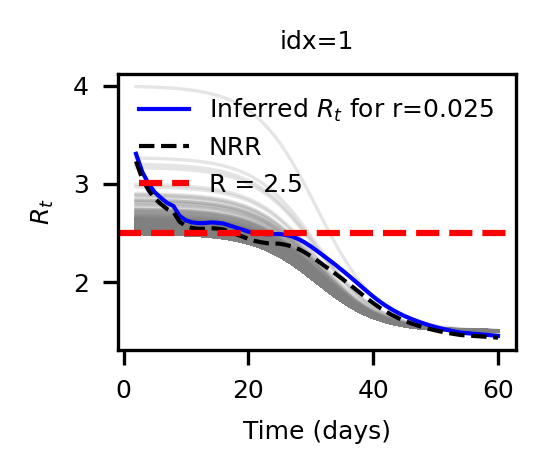

In [330]:
plt.figure(figsize=(2, 1.68), dpi=300) ## was (1.5,1.3) 2, 1.68
# Plot all ensemble Rtx curves

for i in range(3142):
    plt.plot(range(2, 61), Rtx[1:, i], alpha=0.2, lw=0.8, color="grey")

# Plot inferred Rt
plt.plot(
    daily_Rt['day'], daily_Rt['Rt'],
    label=f"Inferred $R_t$ for r={r_dispersion}",   # 
    color='blue', linewidth=1
)

#### for read back usage
# plt.plot(
#     range(2,61), Rt_array[1:60,0], 
#     label=f"fixed alpha = 0.15",   # 
#     color='orange', linewidth=1
# )
plt.plot(
    range(2,61), Rt_array1[1:60,0], 
    label=f"NRR",   # 
    color='Black', linewidth=1,ls ='--'
)

# Reference line at R=2.5
plt.axhline(2.5, color='red', linestyle='--', label='R = 2.5')

# Labels and title
plt.xlabel('Time (days)', fontsize=6)
plt.ylabel('$R_t$', fontsize=6)
# plt.title('Estimated vs Ensemble $R_t$', fontsize=14)

# Grid and legend
# plt.grid(alpha=0.3, linestyle='--')
plt.legend(frameon=False, fontsize=6)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.title('idx={}'.format(g_idx), fontsize=6)
plt.tight_layout()
# plt.show()
# plt.savefig('Rt_inferred_r-{}_rr.png'.format(r_dispersion), dpi=300) #example_

In [331]:
daily_Rt.loc[-1] = [1, daily_Rt.loc[0, 'Rt']]  # copy value from row 0
daily_Rt.index = daily_Rt.index + 1  # shift index
daily_Rt = daily_Rt.sort_index().reset_index(drop=True)
# assert daily_Rt.shape[0] == 60, "Expected 60 days"
Rt_array = np.tile(daily_Rt['Rt'].values.reshape(-1, 1), (1, 3142))
# np.savetxt('../test_rr_output_pop_linear/infered_Rtx/Rt_array_r-{}_rr-{}_linear.csv'.format(r_dispersion,assumed_rates), Rt_array)

np.savetxt(save_path+'infered_Rtx/Rt_array_r-{}_{}_rr.csv'.format(r_dispersion,g_idx), Rt_array)